In [1]:
%load_ext autoreload
%autoreload 2

import torch
from text3d2video.artifacts.animation_artifact import AnimationArtifact

torch.set_grad_enabled(False)   

n_frames = 5
animation = AnimationArtifact.from_wandb_artifact_tag('rumba:latest')
cams, frames = animation.cams_and_frames(n_frames)
uv_verts, uv_faces = animation.texture_data()

In [2]:
# load pipeline
from diffusers.models import ControlNetModel
from diffusers.schedulers import DPMSolverMultistepScheduler
import torch

from text3d2video.generative_rendering.configs import GenerativeRenderingConfig
from text3d2video.generative_rendering.generative_rendering_pipeline import (
    GenerativeRenderingPipeline,
)

device = torch.device("cuda")
dtype = torch.float16

sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"

controlnet = ControlNetModel.from_pretrained(controlnet_repo, torch_dtype=dtype).to(
    device
)

pipe: GenerativeRenderingPipeline = GenerativeRenderingPipeline.from_pretrained(
    sd_repo, controlnet=controlnet, torch_dtype=dtype
).to(device)

pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

64
64
64
64
32
32
32
32
16
16
16
16
8
8
16
16
16
16
16
16
32
32
32
32
32
32
64
64
64
64
64
64


64
64
64
64
32
32
32
32
16
16
16
16
8
8
16
16
16
16
16
16
32
32
32
32
32
32
64
64
64
64
64


 10%|█         | 1/10 [00:00<00:05,  1.67it/s]

64
64
64
64
64
32
32
32
32
16
16
16
16
8
8
16
16
16
16
16
16
32
32
32
32
32
32
64
64
64
64
64
64


 20%|██        | 2/10 [00:00<00:03,  2.16it/s]

64
64
64
64
32
32
32
32
16
16
16
16
8
8
16
16
16
16
16
16
32
32
32
32
32
32
64
64
64
64
64
64
64
64
64
64
32
32
32
32
16
16
16
16
8
8
16
16
16
16
16
16
32
32
32
32
32
32
64
64
64
64
64
64


64
64
64
64
32
32
32
32
16
16
16
16
8
8
16
16
16
16
16
16
32
32
32
32
32
32
64
64
64
64
64


 30%|███       | 3/10 [00:01<00:04,  1.70it/s]

64
64
64
64
64
32
32
32
32
16
16
16
16
8
8
16
16
16
16
16
16
32
32
32
32
32
32
64
64
64
64
64
64


 40%|████      | 4/10 [00:02<00:03,  1.99it/s]

64
64
64
64
32
32
32
32
16
16
16
16
8
8
16
16
16
16
16
16
32
32
32
32
32
32
64
64
64
64
64
64
64
64
64
64
32
32
32
32
16
16
16
16
8
8
16
16
16
16
16
16
32
32
32
32
32
32
64
64
64
64
64
64


 50%|█████     | 5/10 [00:02<00:02,  1.98it/s]

64
64
64
64
32
32
32
32
16
16
16
16
8
8
16
16
16
16
16
16
32
32
32
32
32
32
64
64
64
64
64
64
64
64
64
64
32
32
32
32
16
16
16
16
8
8
16
16
16
16
16
16
32
32
32
32
32
32
64
64
64
64
64
64


64
64
64
64
32
32
32
32
16
16
16
16
8
8
16
16
16
16
16
16
32
32
32
32
32
32
64
64
64
64
64


 60%|██████    | 6/10 [00:03<00:02,  1.71it/s]

64
64
64
64
64
32
32
32
32
16
16
16
16
8
8
16
16
16
16
16
16
32
32
32
32
32
32
64
64
64
64
64
64


 70%|███████   | 7/10 [00:03<00:01,  1.94it/s]

64
64
64
64
32
32
32
32
16
16
16
16
8
8
16
16
16
16
16
16
32
32
32
32
32
32
64
64
64
64
64
64
64
64
64
64
32
32
32
32
16
16
16
16
8
8
16
16
16
16
16
16
32
32
32
32
32
32
64
64
64
64
64
64


 80%|████████  | 8/10 [00:04<00:01,  1.94it/s]

64
64
64
64
32
32
32
32
16
16
16
16
8
8
16
16
16
16
16
16
32
32
32
32
32
32
64
64
64
64
64
64
64
64
64
64
32
32
32
32
16
16
16
16
8
8
16
16
16
16
16
16
32
32
32
32
32
32
64
64
64
64
64
64


64
64
64
64
32
32
32
32
16
16
16
16
8
8
16
16
16
16
16
16
32
32
32
32
32
32
64
64
64
64
64


 90%|█████████ | 9/10 [00:04<00:00,  1.71it/s]

64
64
64
64
64
32
32
32
32
16
16
16
16
8
8
16
16
16
16
16
16
32
32
32
32
32
32
64
64
64
64
64
64


100%|██████████| 10/10 [00:05<00:00,  1.88it/s]

64
64
64
64
32
32
32
32
16
16
16
16
8
8
16
16
16
16
16
16
32
32
32
32
32
32
64
64
64
64
64
64


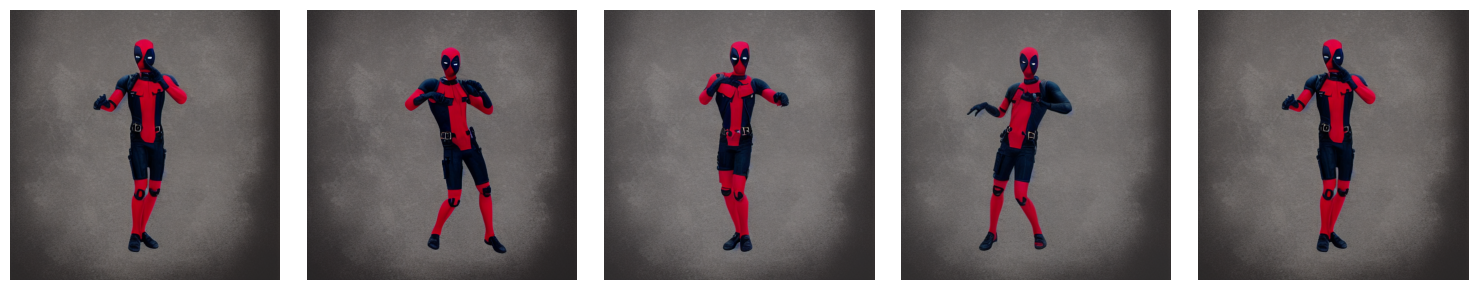

In [6]:
from text3d2video.generative_rendering.configs import (
    GrSaveConfig,
    NoiseInitializationConfig,
    NoiseInitializationMethod,
)
from text3d2video.ipython_utils import display_ims

module_paths = [
    #   "down_blocks.0.attentions.0.transformer_blocks.0.attn1",
    #   "down_blocks.0.attentions.1.transformer_blocks.0.attn1",
    #   "down_blocks.1.attentions.0.transformer_blocks.0.attn1",
    #   "down_blocks.1.attentions.1.transformer_blocks.0.attn1",
    #   "down_blocks.2.attentions.0.transformer_blocks.0.attn1",
    #   "down_blocks.2.attentions.1.transformer_blocks.0.attn1",
    #   "mid_block.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.2.transformer_blocks.0.attn1",
]

gr_config = GenerativeRenderingConfig(
    seed=0,
    resolution=512,
    do_pre_attn_injection=True,
    do_post_attn_injection=False,
    feature_blend_alpha=0.5,
    attend_to_self_kv=False,
    mean_features_weight=0.5,
    chunk_size=5,
    num_keyframes=4,
    num_inference_steps=10,
    guidance_scale=7.5,
    controlnet_conditioning_scale=1.0,
    module_paths=module_paths,
)

save_config = GrSaveConfig(
    enabled=True,
    save_latents=True,
    save_q=True,
    save_k=True,
    save_v=True,
    save_features=False,
    save_features_3d=True,
    n_frames=3,
    n_timesteps=5,
    out_artifact="gr_data",
    module_paths=[] if len(module_paths) == 0 else [module_paths[-1]],
)

noise_config = NoiseInitializationConfig(
    method=NoiseInitializationMethod.UV,
)
noise_config.uv_texture_res = 64

prompt = "Deadpool Dancing"

video_frames = pipe(
    prompt,
    frames,
    cams,
    uv_verts,
    uv_faces,
    generative_rendering_config=gr_config,
    noise_initialization_config=noise_config,
    gr_save_config=save_config,
)

art = pipe.gr_data_artifact

display_ims(video_frames, scale=3)

In [102]:
print(art.folder)
art.print_datasets()

/tmp/tmpzyl0eqal
frame_indices (3,)
time_0/frame_0/latents (4, 64, 64)
time_0/frame_2/latents (4, 64, 64)
time_0/frame_4/latents (4, 64, 64)
time_200/frame_0/latents (4, 64, 64)
time_200/frame_0/layer_up_blocks.3.attentions.2.transformer_blocks.0.attn1/attn_out_post (320, 64, 64)
time_200/frame_0/layer_up_blocks.3.attentions.2.transformer_blocks.0.attn1/attn_out_pre (320, 64, 64)
time_200/frame_0/layer_up_blocks.3.attentions.2.transformer_blocks.0.attn1/key (16384, 320)
time_200/frame_0/layer_up_blocks.3.attentions.2.transformer_blocks.0.attn1/query (4096, 320)
time_200/frame_0/layer_up_blocks.3.attentions.2.transformer_blocks.0.attn1/value (16384, 320)
time_200/frame_2/latents (4, 64, 64)
time_200/frame_2/layer_up_blocks.3.attentions.2.transformer_blocks.0.attn1/attn_out_post (320, 64, 64)
time_200/frame_2/layer_up_blocks.3.attentions.2.transformer_blocks.0.attn1/attn_out_pre (320, 64, 64)
time_200/frame_2/layer_up_blocks.3.attentions.2.transformer_blocks.0.attn1/key (16384, 320)
time

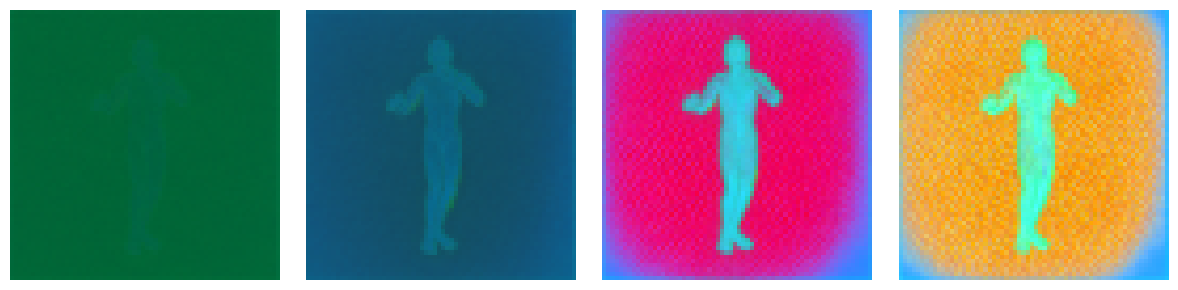

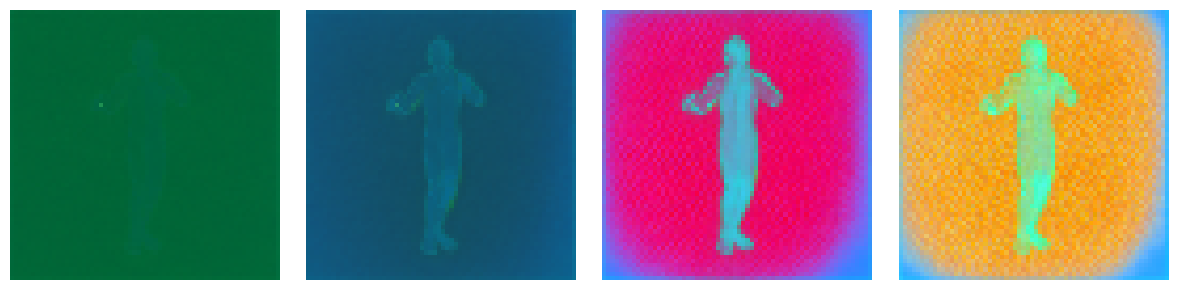

In [105]:
from einops import rearrange

from text3d2video.feature_visualization import RgbPcaUtil


timesteps = art.read_timesteps()
frame_indices = art.read_frame_indices()
modules = art.read_module_paths()

module = modules[0]
frame_idx = frame_indices[0]

features_pre = [art.read_feature(t, frame_idx, module, 'attn_out_pre') for t in timesteps[:-1]]
features_pre = torch.stack(features_pre)

features_post = [art.read_feature(t, frame_idx, module, 'attn_out_post') for t in timesteps[:-1]]

features_flat = rearrange(features_pre, 'b c h w -> (b h w) c')
pca = RgbPcaUtil.init_from_features(features_flat)

feature_ims_pre = [pca.feature_map_to_rgb_pil(f) for f in features_pre]
feature_ims_post = [pca.feature_map_to_rgb_pil(f) for f in features_post]

display_ims(feature_ims_pre, scale=3)
display_ims(feature_ims_post, scale=3)